In [1]:
from obspy import read_events, Catalog, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geothermie_plot_function import *

In [2]:
threshold_event_magnitude = 0.5

In [3]:
catalog = read_events('Downloads/geothermie-events-master/geothermie-events-master/Unterhaching/*.xml')
catnew = Catalog()
cat2013 = Catalog()
eventinfo = []
eventinfo2 = []
for event in catalog:
    try:
        if not (event.origins[0]['time'] > UTCDateTime(2013,1,1) and event.origins[0]['time'] < UTCDateTime(2014,1,1)):
            catnew.append(event)
            eventinfo.append([event.origins[0]['time'],event.magnitudes[0].mag])
        else:
            cat2013.append(event)
            eventinfo2.append([event.origins[0]['time'],event.magnitudes[0].mag])
    except:
        pass
catalog = catnew
roundedtimes = []
magnitudes = []
for time in eventinfo:
    rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
    roundedtimes.append(rtime)
    magnitudes.append(time[1])
roundedtimes, magnitudes = zip(*sorted(zip(roundedtimes, magnitudes)))
print(catalog)
names = 'Time,Flowrate,Temperature,Pressure'
names = names.split(",")
data = pd.read_csv('Dokumente/unterhaching_betriebsdaten_2008-2017/daten20082017.txt',names=names,skiprows=1,delimiter=' ')
N = len(data)
newcol = np.zeros(N)
newcol2 = np.zeros(N)
flc = np.zeros(N)
tc = np.zeros(N)
pc = np.zeros(N)

ievent = 0

eventtimes = np.zeros(N)
eventtimes[0] = 100*365*24
eventtimes[1] = eventtimes[0]+1
newcol2[0] = np.nan
for i in range(1,N):
    if data['Time'][i] in roundedtimes:
        newcol[i] = 1
        N_events_in_this_hour = roundedtimes.count(data['Time'][i])
        
        ## get top magnitude of events in this hour
        mag = max(magnitudes[ievent:ievent+N_events_in_this_hour])
        newcol2[i] = mag
        if mag > threshold_event_magnitude:
            eventtimes[i+1] = 0
        else:
            eventtimes[i+1] = eventtimes[i]+1
        
        ievent += N_events_in_this_hour
    else:
        newcol2[i] = np.nan
        if i!=N-1:
            eventtimes[i+1] = eventtimes[i]+1
        
            
    
    if i==43022:
        roundedtimes2 = []
        magnitudes2 = []
        for time in eventinfo2:
            rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
            roundedtimes2.append(rtime)
            magnitudes2.append(time[1])
        roundedtimes2, magnitudes2 = zip(*sorted(zip(roundedtimes2, magnitudes2)))
        roundedtimes2 = list(roundedtimes2)
        magnitudes2 = list(magnitudes2)
        roundedtimes2.reverse()
        magnitudes2.reverse()
        check = True
        mag = -100
        eventindex = -1
        while (mag < threshold_event_magnitude and check):
            eventindex += 1
            mag = magnitudes2[eventindex]
            if eventindex==len(magnitudes2):
                check = False
        eventtimes[i] = (float(UTCDateTime(2014,1,1))-roundedtimes2[eventindex])/(60**2)

drop = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        drop.append(i)
data.drop(drop)
N = len(data)

for i in range(1,N-1):
    flc[i] = data['Flowrate'][i+1]-data['Flowrate'][i-1]
    tc[i] = data['Temperature'][i+1]-data['Temperature'][i-1]
    pc[i] = data['Pressure'][i+1]-data['Pressure'][i-1]
    

#data['Flowrate diff'] = flc/2
#data['Temp diff'] = tc/2
#data['Press diff'] = pc/2
data['Quiet time'] = eventtimes
data['Event'] = newcol
data['Magnitude'] = newcol2
names.extend(['Flowrate diff','Temp diff','Press diff','Quiet time','Event','Magnitude'])

509 Event(s) in Catalog:
2010-05-27T16:25:25.312700Z | +48.048,  +11.644 | 0.0839474806054 Ml
2010-01-31T08:00:57.025500Z | +48.048,  +11.643 | 0.039033276658 Ml
...
2019-01-18T21:53:12.483393Z | +48.049,  +11.646 | -0.472072504528 None
2019-12-31T17:47:30.953434Z | +48.045,  +11.644 | -0.497145528261 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [4]:
def Confusionmatrix(y,yhat,perc):
    N = len(y)
    C = [[0,0],[0,0]]
    for i in range(N):
        if y[i,0]==1. and yhat[i,0]>=perc:
            C[0][0] += 1
        elif y[i,0]==0. and yhat[i,0]>=perc:
            C[1][0] += 1
        elif y[i,0]==1. and yhat[i,0]<perc:
            C[0][1] += 1
        else:
            C[1][1] += 1
            
    print('True Positives:  ', C[0][0])
    print('False Positives: ', C[1][0])
    print('False Negatives: ', C[0][1])
    print('True Negatives:  ', C[1][1])
    return C

In [67]:
def plot_model_evolution(Loss,b,c,D,U,V,W):
    fig,ax = plt.subplots(nrows=7,figsize=(15,15),sharex=True)
    ax[0].plot(Loss,label='Loss')
    ax[0].set_yscale('log')
    ax[1].plot(c[:,0],label='c1')
    ax[1].plot(c[:,1],label='c2')
    ax[2].plot(b[:,0],label='b1')
    ax[2].plot(b[:,1],label='b2')
    ax[2].plot(b[:,2],label='b3')
    ax[3].plot(V[:,0,0],label='V11')
    ax[3].plot(V[:,0,1],label='V12')
    ax[3].plot(V[:,0,2],label='V13')
    ax[3].plot(V[:,1,0],label='V21')
    ax[3].plot(V[:,1,1],label='V22')
    ax[3].plot(V[:,1,2],label='V23')
    
    ulabels = [['U11','U12','U13'],['U21','U22','U23'],['U31','U32','U33']]
    wlabels = [['W11','W12','W13'],['W21','W22','W23'],['W31','W32','W33']]
    
    for i in range(3):
        for j in range(3):
            ax[4].plot(U[:,i,j],label=ulabels[i][j])
            ax[5].plot(W[:,i,j],label=wlabels[i][j])
        
    dlabels = [['D11','D12','D13'],['D21','D22','D23'],['D31','D32','D33']]
    for i in range(3):
        for j in range(3):
            ax[6].plot(D[:,i,j],label=dlabels[i][j])
            
    for i in range(7):
        ax[i].legend(fontsize=8)
    plt.show() 

In [6]:
def softmax(xx):
    z = np.zeros(len(xx))
    summa = 0
    for i in range(len(xx)):
        z[i] = np.exp(xx[i])
        summa += np.exp(xx[i])
    return z/summa

In [7]:
def ReLu(xx):
    zz = np.zeros(len(xx))
    for i in range(len(xx)):
        if xx[i]>0:
            zz[i] = xx[i]
    return zz

In [8]:
def delta(xx,yy):
    if xx==yy:
        return 1.
    else:
        return 0.

In [51]:
def initialization(Nit,Nd):

    U = np.zeros((Nit,3,3))
    W = np.zeros((Nit,3,3,Nd))
    b = np.zeros((Nit,3,Nd))
    V = np.zeros((Nit,2,3))
    c = np.zeros((Nit,2))
    D = np.zeros((Nit,3,3,Nd-1))

    dU = np.zeros((Nit,3,3))
    dW = np.zeros((Nit,3,3,Nd))
    db = np.zeros((Nit,3,Nd))
    dV = np.zeros((Nit,2,3))
    dc = np.zeros((Nit,2))
    dD = np.zeros((Nit,3,3,Nd-1))

    yhat = np.zeros((Nit+1,N,2))

    Nrandom = 1000

    for i in range(3):
        for j in range(3):
            U[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
            for k in range(Nd):
                W[0,i,j,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom
            for k in range(Nd-1):
                D[0,i,j,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom
        for k in range(Nd):
            b[0,i,k]= (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom  
    for i in range(2):
        for j in range(3):
            V[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        c[0,i] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom     

    Loss = np.zeros(Nit)

    return U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss,D,dD

In [57]:
def prediction(b,c,D,U,V,W,x):
    N = len(x)
    Nd = np.shape(D)[2]+1
    a = np.zeros((N,3,Nd))
    h = np.zeros((N,3,Nd))
    o = np.zeros((N,2))
    yhat = np.zeros((N,2))
    a[0,:,0] = b[:,0] + np.dot(U,x[0])
    h[0,:,0] = np.tanh(a[0,:,0])
    for d in range(1,Nd):
        a[0,:,d] = b[:,d] + np.dot(D[:,:,d-1],h[0,:,d-1])
        h[0,:,d] = np.tanh(a[0,:,d])
    o[0] = c + np.dot(V,h[0,:,Nd-1])
    yhat[0] = softmax(o[0,:])
    for t in range(1,N):
        a[t,:,0] = b[:,0] + np.dot(W[:,:,0],h[t-1,:,0])+np.dot(U,x[t])
        h[t,:,0] = np.tanh(a[t,:,0])
        for d in range(1,Nd):
            a[t,:,d] = b[:,d] + np.dot(W[:,:,d],h[t-1,:,d]) + np.dot(D[:,:,d-1],h[t,:,d-1])
            h[t,:,d] = np.tanh(a[t,:,d])
        o[t] = c + np.dot(V,h[t,:,Nd-1])
        yhat[t,:] = softmax(o[t,:])
    return h,o,yhat

def get_loss(y,yhat):
    N = len(y)
    Loss = 0
    for t in range(N):
        Loss -= y[t,0]*np.log10(yhat[t,0])+(1-y[t,0])*np.log10(yhat[t,1])
    return Loss

def gradients(D,h,o,V,W,x,y,yhat):
    N = len(x)
    Nd = np.shape(W)[2]
    do = np.zeros((N,2))
    for t in range(N):
        do[t,0] = y[t,0]*(1-yhat[t,0])-yhat[t,0]*(1-y[t,0])
        do[t,1] = -y[t,0]*yhat[t,1] * (1-y[t,0])*(1-yhat[t,1])
    do /= np.log(10)
    
    dh = np.zeros((N,3,Nd))
    dh[-1,:,Nd-1] = np.dot(V.transpose(),do[-1])
    for d in range(Nd-2,-1,-1):
        diag = []
        for i in range(3):
            diag.append(1-h[-1,i,d+1]**2)
        diag = np.diag(np.array(diag))
        dh[-1,:,d] = np.dot(D[:,:,d].transpose(),np.dot(diag,dh[-1,:,d+1]))
    
    for t in range(N-2,-1,-1):
        diag = []
        for i in range(3):
            diag.append(1-h[t+1,i,Nd-1]**2)
        diag = np.diag(np.array(diag))
        dh[t,:,Nd-1] = np.dot(V.transpose(),do[t])+np.dot(W[:,:,Nd-1].transpose(),np.dot(diag,dh[t+1,:,Nd-1]))
                            
                            
        for d in range(Nd-2,-1,-1):
            diag = []
            diag2 = []
            for i in range(3):
                diag.append(1-h[t,i,d+1]**2)
                diag2.append(1-h[t+1,i,d]**2)
            diag = np.diag(np.array(diag))
            diag2 = np.diag(np.array(diag2))
            dh[t,:,d] = np.dot(D[:,:,d].transpose(),np.dot(diag,dh[t,:,d+1])) + \
                        np.dot(W[:,:,d].transpose(),np.dot(diag2,dh[t+1,:,d]))

    dc = np.zeros(2)
    for i in range(2):
        dc[i] = np.sum(do[:,i])
    db = np.zeros((3,Nd))
    dV = np.zeros((2,3))
    dW = np.zeros((3,3,Nd))
    dD = np.zeros((3,3,Nd-1))
    dU = np.zeros((3,3))
    
    for i in range(3):
        for d in range(Nd):
            for t in range(N):
                db[i,d] += (1-h[t,i,d]**2)*dh[t,i,d]
    
    for t in range(N):
        dV[0,0] += do[t,0]*h[t,0,-1]
        dV[1,0] += do[t,1]*h[t,0,-1]
        dV[0,1] += do[t,0]*h[t,1,-1]
        dV[1,1] += do[t,1]*h[t,1,-1]
        dV[0,2] += do[t,0]*h[t,2,-1]
        dV[1,2] += do[t,1]*h[t,2,-1]
        
    for t in range(1,N):
        mat2 = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                mat2[i,j] = dh[t,i,0] * x[t,j]
        dU += np.dot(np.diag(np.array([1-h[t,0,0]**2,1-h[t,1,0]**2,1-h[t,2,0]**2])),mat2)
        
    for d in range(Nd-1):
        for t in range(N):
            mat = np.zeros((3,3))
            for i in range(3):
                for j in range(3):
                    mat[i,j] = dh[t,i,d+1] * h[t,j,d]
            dD[:,:,d] += np.dot(np.diag(np.array([1-h[t,0,d+1]**2,1-h[t,1,d+1]**2,1-h[t,2,d+1]**2])),mat)
    
    for d in range(Nd):
        for t in range(1,N):
            mat = np.zeros((3,3))
            for i in range(3):
                for j in range(3):
                    mat[i,j] = dh[t,i,d] * h[t-1,j,d]
            dW[:,:,d] += np.dot(np.diag(np.array([1-h[t,0,d]**2,1-h[t,1,d]**2,1-h[t,2,d]**2])),mat)
    return db,dc,dD,do,dU,dV,dW

In [11]:
def mapx(x):
    Nt, Ni = np.shape(x)
    m = np.zeros((Ni,2))
    for i in range(Ni):
        m[i,0] = np.min(x[:,i])
        m[i,1] = np.max(x[:,i])
    newx = np.zeros(np.shape(x))
    for i in range(Ni):
        for t in range(Nt):
            newx[t,i] = (x[t,i]-m[i,0])/(m[i,1]-m[i,0])
    return newx

In [78]:
#data acquisition
N = len(data)
x = [[],[],[]]
y = [[],[]]
index = 0
for i in range(N):
    if not np.isnan(data['Flowrate'][i]):
        x[0].append(data['Flowrate'][i])
        x[1].append(data['Temperature'][i])
        x[2].append(data['Pressure'][i])
        y[0].append(data['Event'][i])
        y[1].append(data['Magnitude'][i])
x = np.array(x).transpose()
y = np.array(y).transpose()
x = mapx(x)
N = len(x)

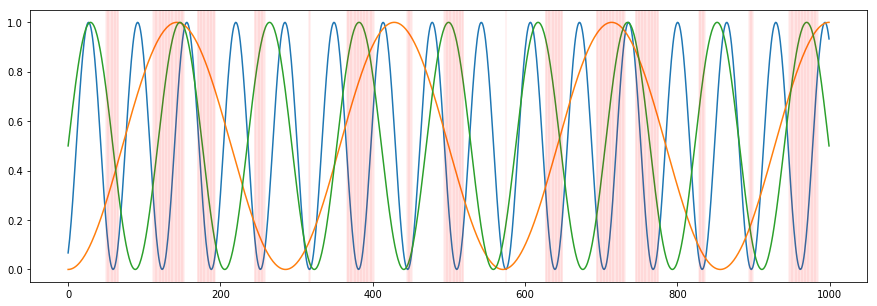

In [101]:
#fake data
N = 1000
x = np.zeros((N,3))
y = np.zeros((N,2))
x[:,0] = (np.sin(np.linspace(0,31*np.pi,N)-np.pi/3)+1)/2
x[:,1] = (np.sin(np.linspace(0,7*np.pi,N)-np.pi/2)+1)/2
x[:,2] = (np.sin(np.linspace(0,17*np.pi,N))+1)/2
plt.figure(figsize=(15,5))
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])
xx = []
yy = []
for i in range(N):
    if x[i,1]*x[i,2]>x[i,0]:
        y[i,0] = 1.
        xx.append(i)
        yy.append(np.max(x[i,0]))
        plt.axvline(i,lw=0.1,c='r')
#plt.scatter(xx,yy,c='r',marker='X')
plt.show()
x = mapx(x)

### RNN-model, fig. 10.4

Adding more depth to the neural network by adding hidden layers.

In [46]:
for i in range(1,10):
    counter = 3*i+2+9*i+9+6+9*i
    print(i,counter)

1 38
2 59
3 80
4 101
5 122
6 143
7 164
8 185
9 206


In [106]:
Nit = 2000
eps = 0.001
Nd = 3

U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss,D,dD = initialization(Nit,Nd)

for k in range(Nit):
    h,o,yhat[k] = prediction(b[k],c[k],D[k],U[k],V[k],W[k],x)
    Loss[k] = get_loss(y,yhat[k])
    print(k,Loss[k])
    db[k],dc[k],dD[k],do,dU[k],dV[k],dW[k] = gradients(D[k],h,o,V[k],W[k],x,y,yhat[k])
    
    if k+1<Nit:
        U[k+1] = U[k] + eps*dU[k]
        W[k+1] = W[k] + eps*dW[k]
        V[k+1] = V[k] + eps*dV[k]
        b[k+1] = b[k] + eps*db[k]
        c[k+1] = c[k] + eps*dc[k]
        D[k+1] = D[k] + eps*dD[k]

    

0 357.824589509
1 308.440614347
2 286.561697505
3 276.387030255
4 271.338466963
5 268.779351855
6 267.272434118
7 266.167749335
8 265.134119472
9 263.985126206
10 262.569136196
11 260.840284181
12 258.912011934
13 256.90484538
14 254.445553329
15 251.830809616
16 248.501745275
17 246.213465446
18 243.203211823
19 242.470734211
20 254.80670683
21 276.386092994
22 240.408264313
23 225.010434219
24 216.582778212
25 226.739832152
26 280.060828841
27 208.941425366
28 202.118049088
29 222.319679332
30 228.031407721
31 245.708995397
32 181.181605006
33 171.366160907
34 162.563026694
35 153.8730311
36 145.153579711
37 141.166178789
38 178.954020913
39 276.516856806
40 141.000329005
41 138.702128418
42 169.503333802
43 179.82074712
44 155.653167841
45 159.350918682
46 175.711387507
47 173.274455352
48 147.522723072
49 135.221844505
50 174.398404153
51 152.165827205
52 174.155321985
53 128.510265021
54 137.697480231
55 113.563823249
56 114.67008292
57 109.162189643
58 114.28394812
59 111.5655103

465 45.3473160248
466 47.0021781926
467 45.1532911774
468 46.7538560739
469 44.9580839064
470 46.5017722011
471 44.7538491381
472 46.2389105554
473 44.5344669997
474 45.9654002612
475 44.3077060939
476 45.6885000927
477 44.0877225662
478 45.3950509729
479 43.8738530641
480 45.0845342471
481 43.6759444152
482 44.799807253
483 43.5190728279
484 44.5819448819
485 43.4185544691
486 44.4323026898
487 43.3623217592
488 44.3089971653
489 43.3130085469
490 44.1500339876
491 43.228442688
492 43.911511126
493 43.0893828259
494 43.5989840862
495 42.9151606225
496 43.2677579652
497 42.7545774023
498 42.9908113173
499 42.6581935338
500 42.8177013995
501 42.648457243
502 42.7459809771
503 42.7011335144
504 42.7144465931
505 42.7487930647
506 42.6276855932
507 42.7146802758
508 42.4146000902
509 42.5652797573
510 42.0860224364
511 42.3415359153
512 41.7355043534
513 42.1380320054
514 41.4794272538
515 42.0467175284
516 41.3895777684
517 42.1044143427
518 41.4549579802
519 42.2658287689
520 41.5760160

923 36.9844822313
924 37.3206624326
925 46.198766057
926 45.7151598738
927 56.62408116
928 46.639103153
929 49.7465033127
930 33.5115601723
931 29.2309326599
932 26.3078660426
933 25.7395753998
934 25.2973204167
935 25.4381852995
936 25.327423497
937 26.3601864051
938 26.3256871836
939 28.3143339889
940 27.1561181123
941 28.7348841353
942 28.3654832096
943 31.6231679197
944 29.5816340464
945 31.9310443027
946 33.8110530686
947 42.3704010413
948 34.6200080354
949 43.6884678497
950 59.0145309314
951 67.9087761991
952 35.3470473168
953 31.1160261437
954 27.426151684
955 26.5719721071
956 25.8768325869
957 25.5584852029
958 25.2245581765
959 25.3769209129
960 25.4198932212
961 26.3951127851
962 27.0627487417
963 29.2278744635
964 29.7994563329
965 32.6126889913
966 33.7083153408
967 38.8573151357
968 40.2127435316
969 50.6067898247
970 46.8959046669
971 50.5391675273
972 39.4995983638
973 34.9840369295
974 28.9643810848
975 26.4943344291
976 25.1391161345
977 25.1654358379
978 25.004481042

1361 25.7247090442
1362 24.1117248912
1363 27.6840384753
1364 24.6772823306
1365 26.6916231709
1366 27.9675891372
1367 39.5099801327
1368 22.4562246712
1369 21.3482510654
1370 21.7082012373
1371 23.5152154481
1372 23.9997105107
1373 30.2052478024
1374 26.5237528793
1375 30.0669139492
1376 61.1345915957
1377 54.4146082325
1378 36.0289536014
1379 33.3936844719
1380 26.6168218521
1381 23.8398842014
1382 22.6789006572
1383 22.294693828
1384 21.8186263598
1385 22.1053748034
1386 22.0398134441
1387 23.2053215754
1388 23.3918977717
1389 26.1067091762
1390 25.0742411046
1391 28.5809366144
1392 27.7372680628
1393 36.6088040928
1394 37.0951712893
1395 43.0718516588
1396 46.1026697388
1397 46.4714978916
1398 57.0010950943
1399 36.0944408574
1400 30.5409090965
1401 31.097200013
1402 25.7551772348
1403 23.5381074176
1404 22.5828408935
1405 22.2177032924
1406 21.729671778
1407 21.7785434335
1408 21.5517036294
1409 22.2159331923
1410 22.2574902955
1411 24.047938948
1412 24.0246669717
1413 27.50724154

1795 29.0614579213
1796 23.3471441919
1797 21.7100969318
1798 20.3228364725
1799 19.3977622
1800 18.5747439986
1801 18.0747845165
1802 17.7279028714
1803 18.0827805201
1804 19.7085307881
1805 26.8663305686
1806 18.2231995406
1807 17.308755054
1808 16.8029600817
1809 16.4968504459
1810 16.8903809921
1811 17.8017530573
1812 26.3220034502
1813 18.9986448019
1814 17.9645202798
1815 18.2970577496
1816 22.2995447992
1817 29.2675176834
1818 19.4785197509
1819 20.3886141649
1820 24.7129904134
1821 33.5809601526
1822 30.0542421665
1823 40.3801391812
1824 41.2061454364
1825 41.5200069784
1826 35.1985518623
1827 32.2310360718
1828 23.542433254
1829 19.7638580252
1830 19.1899943698
1831 19.9473794667
1832 20.8031286381
1833 23.1208931742
1834 23.5328133764
1835 30.2783002043
1836 25.4890627161
1837 30.7348687185
1838 32.6624374954
1839 40.372297637
1840 37.1465696115
1841 39.0447088519
1842 39.7058632608
1843 45.6298861888
1844 33.4672399763
1845 27.7703098036
1846 22.6499017529
1847 22.163998258


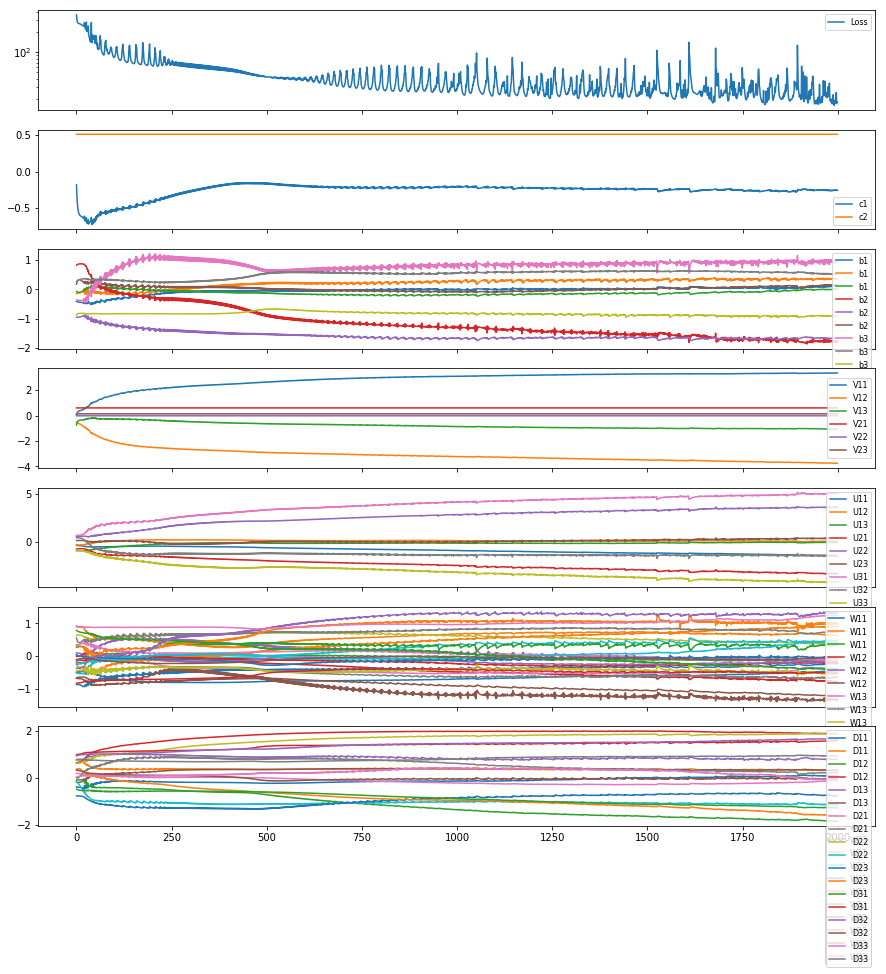

In [107]:
plot_model_evolution(Loss,b,c,D,U,V,W)

In [108]:
_,_,pred = prediction(b[-1],c[-1],D[-1],U[-1],V[-1],W[-1],x)

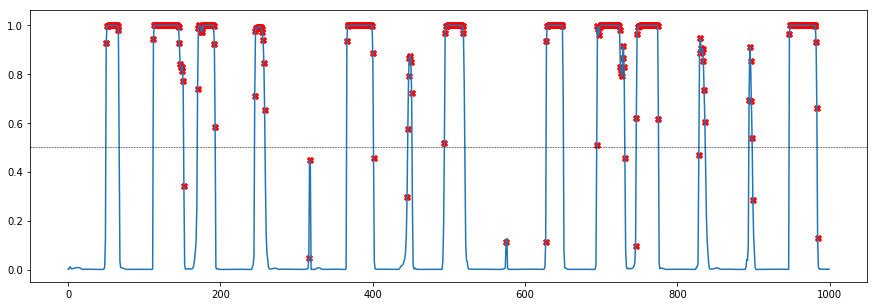

True Positives:   301
False Positives:  3
False Negatives:  12
True Negatives:   684


In [109]:
q = 0.5

plt.figure(figsize=(15,5))
plt.plot(pred[:,0])
for i in range(N):
    if y[i,0]==1.:
        plt.scatter(i,pred[i,0],c='r',marker='X')
plt.axhline(q,lw=0.5,ls='dashed',c='k')
#plt.yscale('log')
plt.show()

C = Confusionmatrix(y,pred,q)